# 데이터와 라이브러리 로딩

## 구글드라이브 마운트 및 필요한 라이브러리 로딩  
코랩과 구글드라이브를 연동하기 위해 google.colab에서 drive 메서드를 불러와서 실행한다.
*/content/drive 이후 디렉터리는 개인에 따라 다르다
- 이 부분은 Jupyter Notebook에서 작업시에는 불필요하다.

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## 필요한 라이브러리들 import
 

In [0]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import numpy as np
import datetime as dt
from datetime import timedelta

## AFSNT 불러오기
대회에서 제공된 AFSNT.csv 를 불러온다

In [0]:
AFSNT = pd.read_csv('/content/gdrive/My Drive/test_colab/AFSNT.csv', engine = "python")

# 데이터 전처리

## 파생변수-날짜열 가공, 당일 할당된 항공편수

In [0]:
# Date 열 만들기
AFSNT=AFSNT.rename(columns={'SDT_YY':'Year','SDT_MM':'Month','SDT_DD':'Day'})
AFSNT['Date']=pd.to_datetime(AFSNT.loc[:, ['Year','Month','Day']])
AFSNT=AFSNT.drop(['Year','Month','Day','SDT_DY'],axis=1)

#당일 할당된 항공편수 피쳐 만들기
afsnt_count=AFSNT.groupby(['Date','ARP']).size().to_frame()
afsnt=pd.merge(AFSNT,afsnt_count,on=['Date','ARP'])
AFSNT = afsnt.rename(columns={0:'flights'})



## 데이터 다듬기(Trimming)  
1. 원활한 모델링을 위해 충분한 데이터를 가지지않은 소수 공항을 제거한다.
2. 지연 여부를 예측할 클래스 레이블로 하기 위해 결항인 데이터는 제외한다.  
(결항인 경우 DLY가 N으로 되어있기 때문에 학습과 EDA에 지장이 생긴다.)
3. 학습

In [0]:
# 1.소수 공항 제거
AFSNT=AFSNT[AFSNT.FLO!='C']
AFSNT=AFSNT[AFSNT.FLO!='D']
AFSNT=AFSNT[AFSNT.FLO!='E']
AFSNT=AFSNT[AFSNT.FLO!='G']
AFSNT=AFSNT[AFSNT.FLO!='K']

# 2.결항 제거
AFSNT=AFSNT[AFSNT.CNL=='N']

# 3.필요한 열만 포함
AFSNT=AFSNT.loc[:,['Date','ARP', 'ODP', 'FLO','FLT','REG', 'AOD','IRR', 'STT', 'ATT', 'DLY', 'DRR', 'CNL', 'CNR','flights']]

In [0]:
# STT, ATT에서 시간만 추출
STT_hour=AFSNT['STT'].str.split(':').str.get(0).astype('float64')
ATT_hour=AFSNT['ATT'].str.split(':').str.get(0).astype('float64')

In [0]:
#STT 시간 데이터를 STT_minute으로 hour와 minute을 합쳤다.
def getValuebyminute(STT):
  hour,minute=STT.split(':')
  hour=float(hour)
  minute=float(minute)
  return hour*60+minute

AFSNT['STT_minute']=AFSNT['STT'].apply(getValuebyminute)


# Slot 배정 관련 변수 slots 구하기
arp_sort=AFSNT.sort_values(by=['Date','ARP','STT_minute'])
sttlen=int((max(arp_sort['STT_minute'])-min(arp_sort['STT_minute']))/10)
#print(sttlen)

def TTto60(TT):
    return int(TT/sttlen)
arp_sort['STT_category']=arp_sort['STT_minute'].apply(TTto60)


#timetable['stt_category']=arp_sort.groupby(['DATE','ARP','STT_category']).size()
#arp_sort.groupby(['DATE','ARP','STT_category']).size().rolling(window=3)
timetable=pd.DataFrame()
timetable=arp_sort.groupby(['Date','ARP','STT_category']).size()

windowsize=5
timetable=timetable.to_frame()
AFSNT=pd.merge(left=arp_sort,right=timetable,on=['Date','ARP','STT_category'])
AFSNT = AFSNT.rename(columns={0:'slots'})

In [0]:
# 하루가 넘어간 데이터 찾기
over_time_idx=AFSNT.loc[(STT_hour>ATT_hour)&(AFSNT.DLY=='Y'),:].index

# STT_detail, ATT_detail 생성
AFSNT['STT_detail']=pd.to_datetime(AFSNT['Date'].astype('str')+' '+AFSNT['STT'])
AFSNT['ATT_detail']=pd.to_datetime(AFSNT['Date'].astype('str')+' '+AFSNT['ATT'])

# 하루 더해주기
AFSNT.loc[over_time_idx,'ATT_detail']=AFSNT.loc[over_time_idx,'ATT_detail']+pd.DateOffset(days=1)
AFSNT.loc[over_time_idx,:]

,Date,ARP,ODP,FLO,FLT,REG,AOD,IRR,STT,ATT,DLY,DRR,CNL,CNR,flights,STT_minute,STT_category,slots,STT_detail,ATT_detail
89,2017-01-01,ARP1,ARP3,A,A1983,SEw3MjQ3,D,N,11:05,11:55,Y,C02,N,NaN,344,665.0,4,49,2017-01-01 11:05:00,2017-01-02 11:55:00
186,2017-01-01,ARP1,ARP3,L,L1715,SEw4MDY3,D,N,15:15,16:40,Y,C02,N,NaN,344,915.0,6,57,2017-01-01 15:15:00,2017-01-02 16:40:00
380,2017-01-01,ARP2,ARP3,I,I1561,SEw3NTY0,D,N,7:05,7:36,Y,C02,N,NaN,140,425.0,2,5,2017-01-01 07:05:00,2017-01-02 07:36:00
919,2017-01-01,ARP3,ARP1,J,J1249,SEw3NzI3,D,N,21:05,21:36,Y,C02,N,NaN,424,1265.0,8,72,2017-01-01 21:05:00,2017-01-02 21:36:00
2053,2017-01-02,ARP6,ARP3,J,J1959,SEw3NzA1,A,N,17:10,17:41,Y,C02,N,NaN,36,1030.0,7,12,2017-01-02 17:10:00,2017-01-03 17:41:00
3486,2017-01-04,ARP15,ARP2,J,J1408,SEw3NzE2,D,N,17:15,18:17,Y,C02,N,NaN,14,1035.0,7,3,2017-01-04 17:15:00,2017-01-05 18:17:00
3709,2017-01-04,ARP3,ARP2,F,F1904,SEw4MDM1,D,N,10:40,11:13,Y,C02,N,NaN,408,640.0,4,64,2017-01-04 10:40:00,2017-01-05 11:13:00
4016,2017-01-04,ARP3,ARP1,I,I1331,SEw3NTU4,A,N,21:35,22:11,Y,C02,N,NaN,408,1295.0,9,6,2017-01-04 21:35:00,2017-01-05 22:11:00
4442,2017-01-05,ARP1,ARP3,H,H1146,SEw4MDg3,A,N,19:40,20:21,Y,C02,N,NaN,342,1180.0,8,43,2017-01-05 19:40:00,2017-01-06 20:21:00
4501,2017-01-05,ARP12,ARP1,J,J1637,SEw3NzE3,D,N,20:30,21:23,Y,C02,N,NaN,4,1230.0,8,2,2017-01-05 20:30:00,2017-01-06 21:23:00


In [0]:
# 지연시간 열 (INT) 구하기
AFSNT['Interval']=AFSNT['ATT_detail']-AFSNT['STT_detail']
AFSNT=AFSNT.rename(columns={'Interval':'INT'})
AFSNT['INT']=pd.to_timedelta(AFSNT['INT'],unit='m').astype('timedelta64[m]')

In [0]:
def weekdayn(Date):
  return Date.weekday()

# 시각 열 생성
def gethour(STT):
  hour,minute=STT.split(':')
  return hour
def getValuebyminute(STT):
  hour,minute=STT.split(':')
  hour=float(hour)
  minute=float(minute)
  return hour*60+minute
def mysum(a,b):
  return a+b
AFSNT['Weekday']=AFSNT['Date'].apply(weekdayn)
AFSNT['STT_minute']=AFSNT['STT'].apply(getValuebyminute)
AFSNT['ATT_minute']=np.sum(AFSNT.loc[:,['STT_minute','INT']],axis=1)

In [0]:
# STT에서 hour 추출
AFSNT['Hour']=AFSNT['STT_detail'].dt.hour

# IRR 파악
부정기편을 추출하고 IRR을 파악한다.

In [0]:
AFSNT_irr=AFSNT[AFSNT['IRR']=='Y'] # IRR인 항공편 추출

In [0]:
STTtime = AFSNT.groupby(['Hour', 'DLY']).size().unstack()
STTtime['Total'] = STTtime['N'] + STTtime['Y']
STTtime = STTtime.loc[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23], :].reset_index()
STTtime

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


DLY,Hour,N,Y,Total
0,0,79.0,18.0,97.0
1,1,11.0,3.0,14.0
2,2,1.0,NaN,NaN
3,3,NaN,NaN,NaN
4,4,NaN,NaN,NaN
5,5,10.0,14.0,24.0
6,6,19070.0,958.0,20028.0
7,7,46559.0,2349.0,48908.0
8,8,60240.0,4835.0,65075.0
9,9,65816.0,5387.0,71203.0


In [0]:
STTtime_irr = AFSNT_irr.groupby(['Hour', 'DLY']).size().unstack()
STTtime_irr['Total'] = STTtime_irr['N'] + STTtime_irr['Y']
STTtime_irr= STTtime_irr.loc[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23], :].reset_index()
STTtime_irr

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


DLY,Hour,N,Y,Total
0,0,68.0,13.0,81.0
1,1,9.0,2.0,11.0
2,2,1.0,NaN,NaN
3,3,NaN,NaN,NaN
4,4,NaN,NaN,NaN
5,5,10.0,14.0,24.0
6,6,1229.0,142.0,1371.0
7,7,1659.0,172.0,1831.0
8,8,1088.0,171.0,1259.0
9,9,1325.0,182.0,1507.0


- 부정기편의 비율을 표로 나타냈다

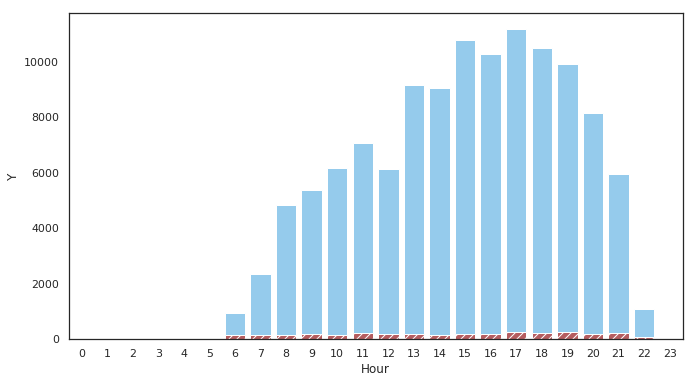

In [0]:
import matplotlib.pyplot as plt
fig = plt.figure(1, figsize=(11,6))
ax = sns.barplot(x="Hour", y="Y", data=STTtime, color="lightskyblue")
ax = sns.barplot(x="Hour", y="Y", data=STTtime_irr, color="r", hatch = '///')   #IRR이 차지하는 비율이 매우 작음

(0, 1000)

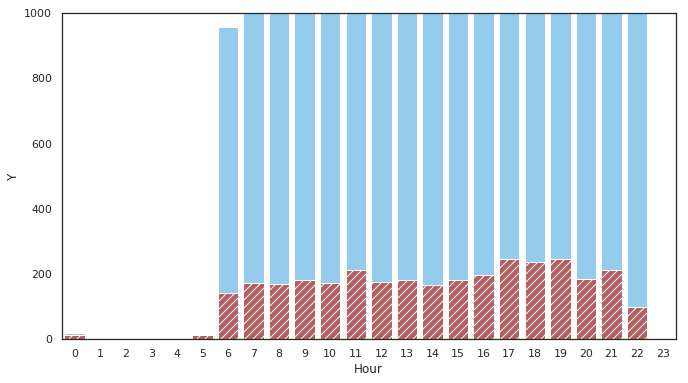

In [0]:
fig = plt.figure(1, figsize=(11,6))
ax = sns.barplot(x="Hour", y="Y", data=STTtime, color="lightskyblue")
ax = sns.barplot(x="Hour", y="Y", data=STTtime_irr, color="r", hatch = '///') 
plt.ylim(0,1000)
# scaling

In [0]:
# 전체 항공편 대비 IRR의 비율
len(AFSNT_irr)/len(AFSNT)*100

2.1737909685218404

# 지연시간 이상치

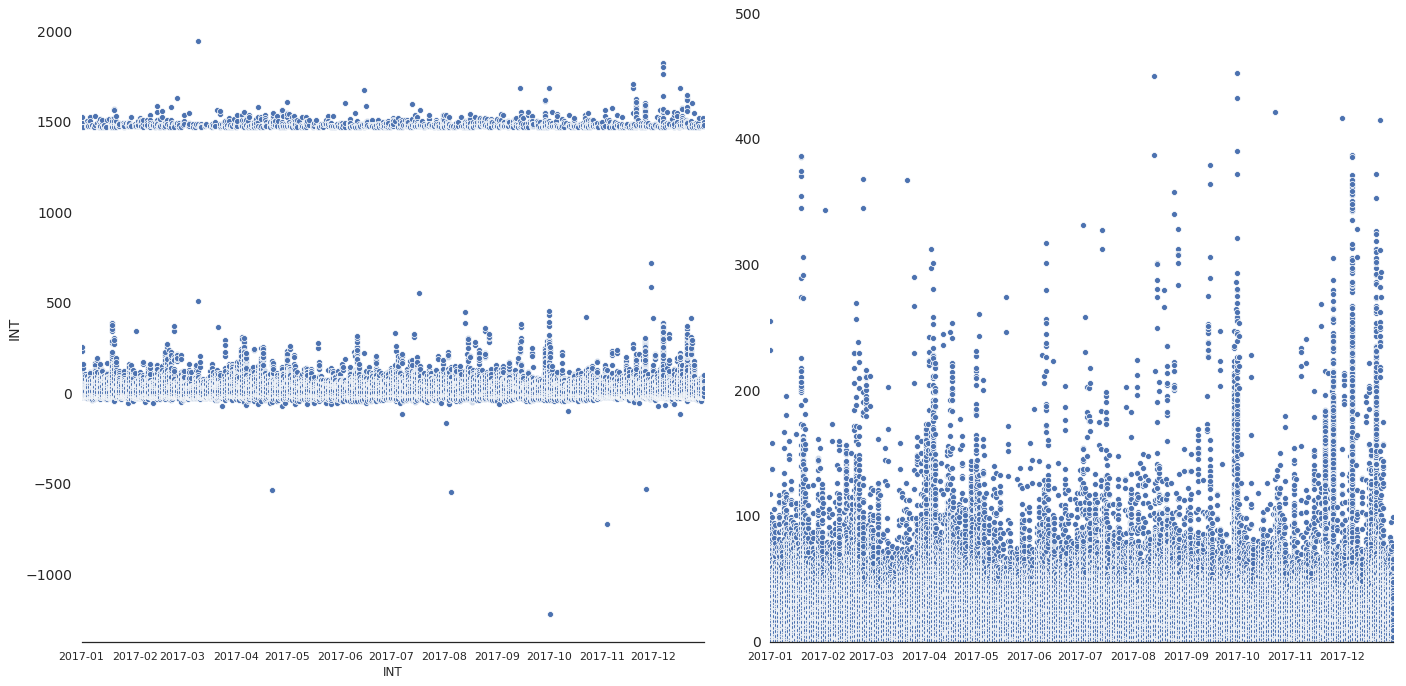

In [0]:
df_ts = AFSNT.loc[:, ['Date', 'INT']]
df_ts['Date'] = pd.to_datetime(df_ts['Date'])
df_ts['Year'] = df_ts['Date'].dt.year
df_2017 = df_ts[df_ts['Year'] == 2017]


sns.set_style("white")
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 10))

sns.scatterplot(x = "Date", y = "INT", data = df_2017, ax = ax1); ax1.set_xlabel(""); ax1.set_xlabel("INT");
sns.scatterplot(x = "Date", y = "INT", data = df_2017, ax = ax2); ax2.set_xlabel(""); ax2.set_ylabel("");
ax1.set(xlim = ('2017-01-01', '2017-12-31'))
ax2.set(xlim = ('2017-01-01', '2017-12-31'))
ax2.set(ylim = (-1, 500))
sns.despine(left= True)
for item in ([ax1.yaxis.label] + ax1.get_yticklabels()):
  item.set_fontsize(14)
for item in ([ax2.yaxis.label] + ax2.get_yticklabels()):
  item.set_fontsize(14)
plt.tight_layout(pad = 2)

###지연요인별 지연시간 분석
- 아래와 같은 지연요인-지연시간(INT) 경향성을 확인할 수 있다

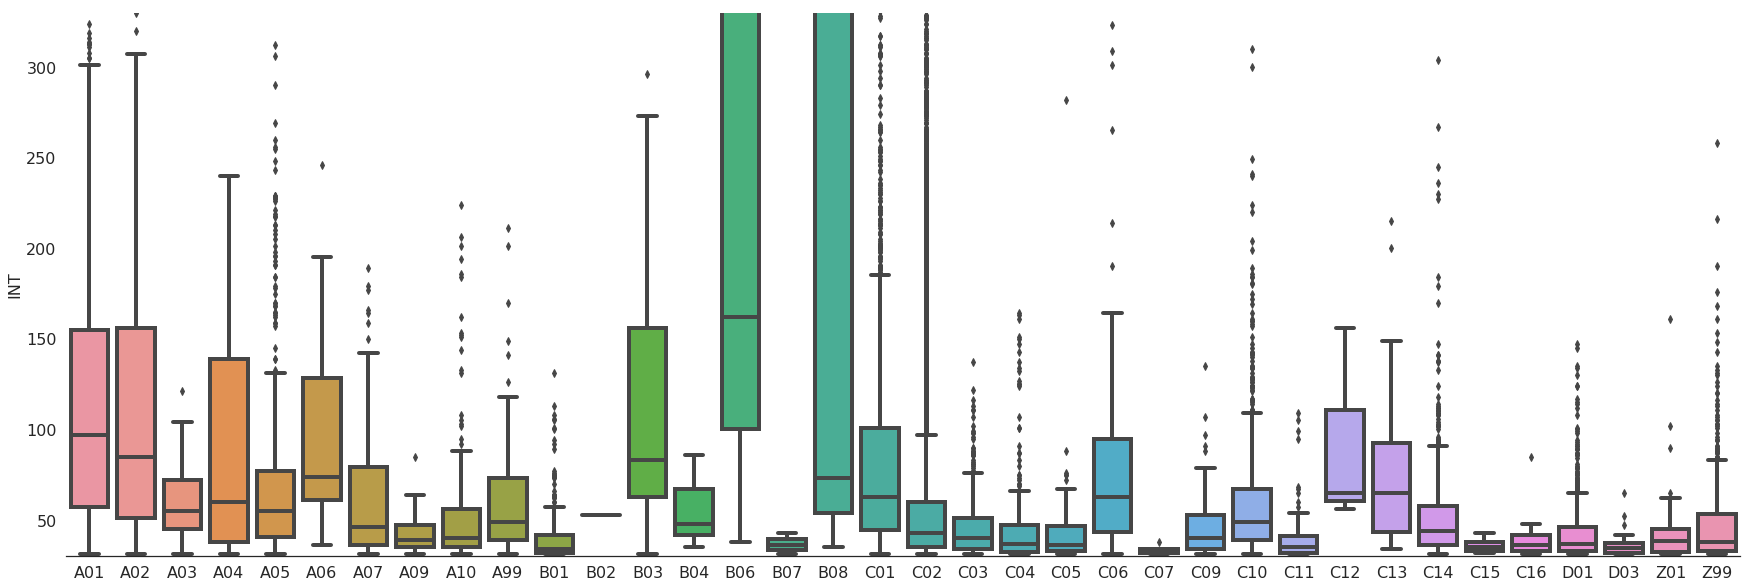

In [0]:
#지연 요인 별 분석
df_drr2 = AFSNT.loc[:, ['DRR', 'INT']]
df_drr2 = df_drr2.sort_values(by= ['DRR'])

fig = plt.figure(figsize = (30, 10))
sns.set_style("white")
color = sns.set_palette("Blues", n_colors = 20)
ax = sns.boxplot(x = 'DRR', y = 'INT', data = df_drr2, palette = color); ax.set_xlabel("");
ax.set(ylim = (30, 330))

for item in ([ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
  item.set_fontsize(16)

sns.despine(left = True)

plt.show()

In [0]:
# IRR 제거
#AFSNT=AFSNT.loc[AFSNT['IRR']=='N'] 

In [0]:
AFSNTh=AFSNT.copy()

# 이상치 처리

In [0]:
print(AFSNT.INT.max())
print(AFSNT.INT.quantile(0.99))
print(AFSNT.INT.min())

1943.0
121.0
-1421.0


-아래와 같이 INT 양끝의 일부분을 버린다

In [0]:
AFSNT['INT']=AFSNT['INT'].apply(lambda x : 91.0 if x>91.0 else x)
AFSNT['INT']=AFSNT['INT'].apply(lambda x : 0.0 if x<0.0 else x)

# EDA - 지연요인 분석

- 지연요인별로 EDA figure를 그림

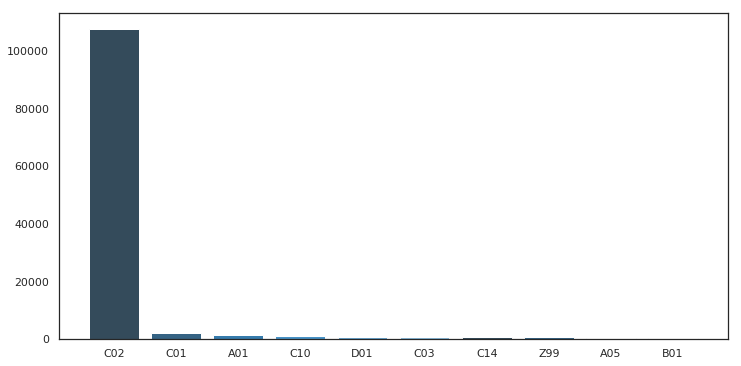

In [0]:
Delay=AFSNT[AFSNT.DLY=='Y']
Delay_reason=Delay.groupby('DRR').DLY.count().to_frame()
Delay_reason=Delay_reason.reset_index()
Delay_reason10=Delay_reason.sort_values(by='DLY',ascending=False).head(10)
my_cmap = sns.color_palette("Blues_d")
plt.bar(Delay_reason10['DRR'],Delay_reason10['DLY'], color = my_cmap)
plt.grid(False)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


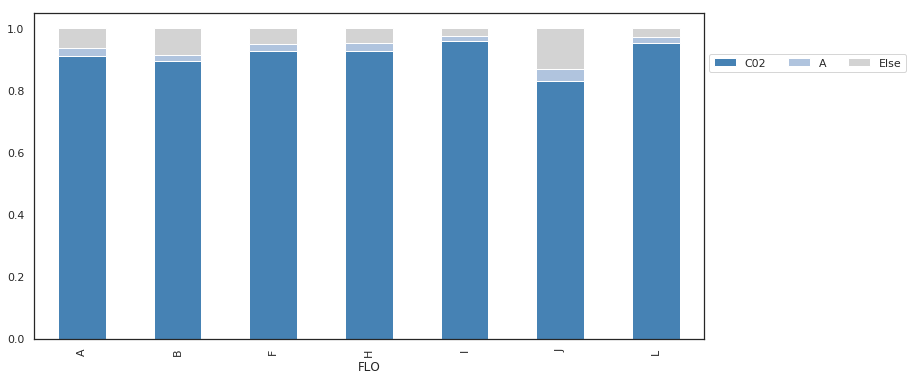

In [0]:
# 지연 요인 그룹화
a_index=AFSNT[AFSNT.DRR.notnull()].DRR[(AFSNT[AFSNT.DRR.notnull()].DRR.str[0]=='A')].index
AFSNT['new_DRR']=AFSNT['DRR']
AFSNT['new_DRR'].loc[a_index]='A'
AFSNT['new_DRR']=np.where((AFSNT.new_DRR=='C02')|(AFSNT.new_DRR=='A')|(AFSNT.new_DRR.isnull()),AFSNT.new_DRR,'Else')
afsnt_plot=AFSNT.groupby('FLO')['new_DRR'].value_counts(normalize=True).unstack()[['C02','A','Else']]
colors = ['steelblue',"lightsteelblue","lightgrey"]
afsnt_plot.plot(kind='bar',stacked=True,color=colors)
plt.legend(loc='lower left',ncol=5, bbox_to_anchor=(1, 0.8))

# 항공사 EDA

In [0]:
# x와 y의 비율 plot
def stack_plot(x,y,df): 
    forstack=df.groupby([x,y]).size().unstack()
    forstack=forstack.transpose()
    if y=="DLY":
        forstack = forstack.div(forstack.sum()).transpose().sort_values('Y')
    else:
        forstack = forstack.div(forstack.sum()).transpose()
    forstack.plot(kind='bar',stacked=True,color=['steelblue','lightgrey'])

- 항공사별 지연비율을 확인하였고, 항공사마다 큰 차이가 없음을 확인할 수 있다

J    273201
A    175545
B    134198
H    131244
I     94473
F     87479
L     83301
Name: FLO, dtype: int64


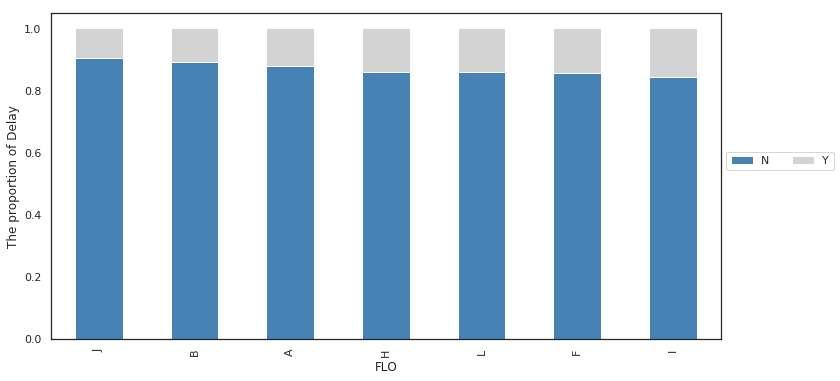

In [0]:
# 항공사별 지연 비율
stack_plot('FLO','DLY',AFSNT)
plt.legend(loc='lower left',ncol=5, bbox_to_anchor=(1, 0.5))
plt.ylabel('The proportion of Delay')
print(AFSNT['FLO'].value_counts())
plt.grid(False)

In [0]:
# 항공사별 전체 항공편수, 지연 항공편수
flo2 = AFSNT.groupby(['FLO', 'DLY']).size().unstack()
flo2['Total'] = flo2['N'] + flo2['Y']
flo2 = flo2.loc[['A','B','F','H','I','J','L'], :].reset_index()
flo2

DLY,FLO,N,Y,Total
0,A,154467,21078,175545
1,B,119610,14588,134198
2,F,74946,12533,87479
3,H,112921,18323,131244
4,I,79794,14679,94473
5,J,247285,25916,273201
6,L,71481,11820,83301


Text(0, 0.5, '')

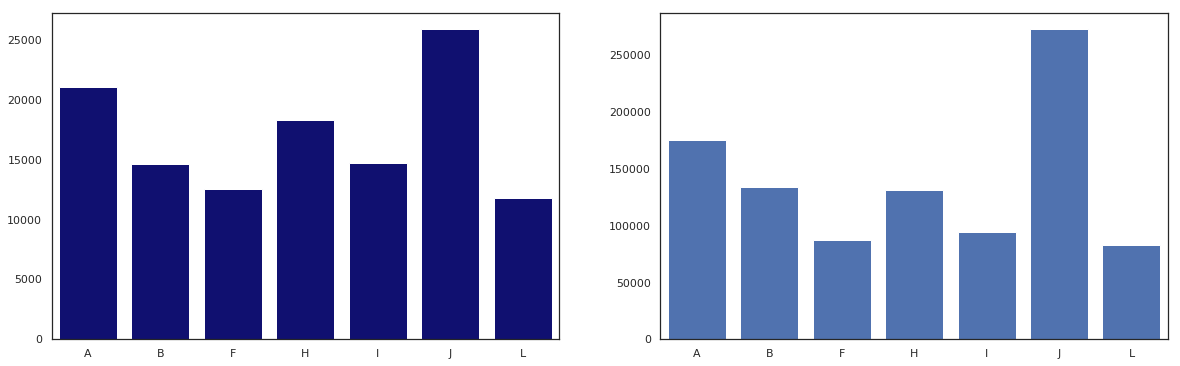

In [0]:
# 지연 항공편 수 & 전체 항공편 수 그래프
sns.set_style("white")
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 6))
sns.barplot(x = flo2['FLO'], y = flo2['Y'], color = 'navy', ax = ax1); ax1.set_xlabel(""); ax1.set_ylabel("") 
sns.barplot(x = flo2['FLO'], y = flo2['Total'], color = "#406dbf", ax = ax2); ax2.set_xlabel(""); ax2.set_ylabel("")

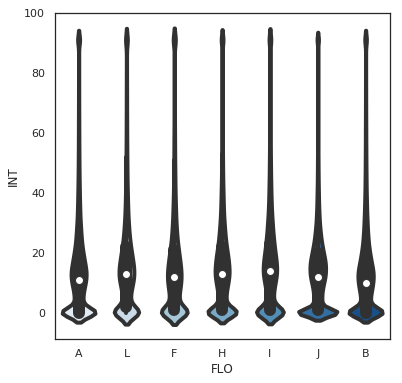

In [0]:
# 항공사별 지연시간 분포 violin plot
plt.figure(figsize=(6,6))
ax=sns.violinplot(data=AFSNT,x='FLO',y='INT',palette='Blues')

- 출도착에 따른 INT의 비대칭성을 확인할 수 있다.

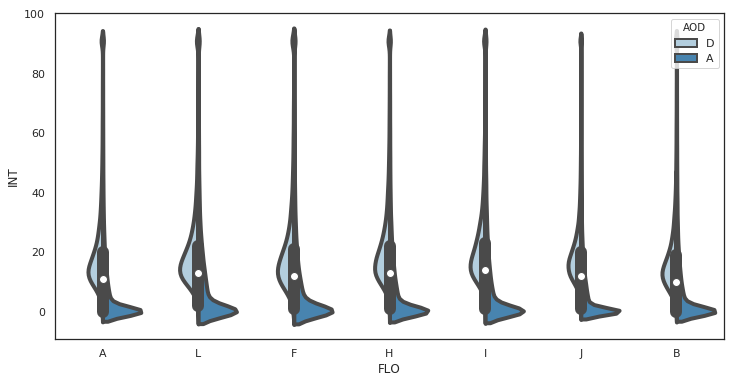

In [0]:
# AOD 따라 나눈 것
sns.violinplot(x='FLO',y='INT',hue='AOD',data = AFSNT,split=True,palette='Blues')


# 계획시각 EDA

In [0]:
# 계획시각에 따른 지연 항공편 수
AFSNT['Delay2']=AFSNT['DLY'].replace("Y",1).replace("N",0)
AFSNT['Delay2'] = list(map(int, AFSNT['Delay2']))
AFSNT_2=AFSNT.loc[:,['Hour','Delay2','DLY']]
hour_group0 = AFSNT_2.groupby('Hour', axis = 0).sum()
hour_group0 = hour_group0.reset_index()
hour_group0

,Hour,Delay2
0,0,18
1,1,3
2,2,0
3,5,14
4,6,958
5,7,2349
6,8,4835
7,9,5387
8,10,6174
9,11,7055


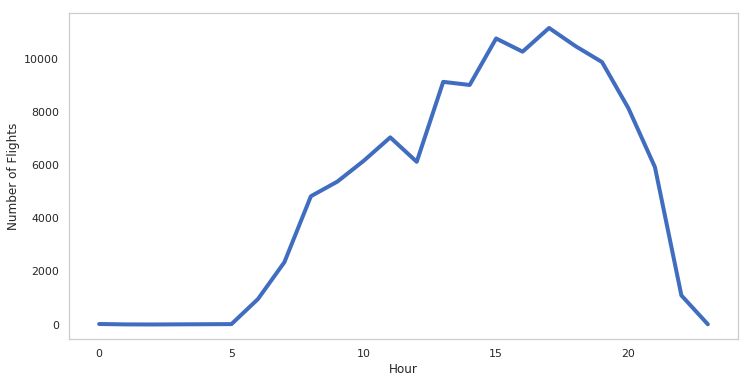

In [0]:
# 계획시각에 따른 지연 항공편 수
sns.set(rc={'figure.figsize':(12,6), "lines.linewidth" : 4}, style="whitegrid")
sns.lineplot(x = 'Hour', y = 'Delay2', data = hour_group0, ci = None,color='#406dbf')
#sns.lineplot(x = 'Hour', y = 'Delay2', data = hour_group0, ci = None,color='#40adbf')
plt.ylabel("Number of Flights")
plt.grid(False)

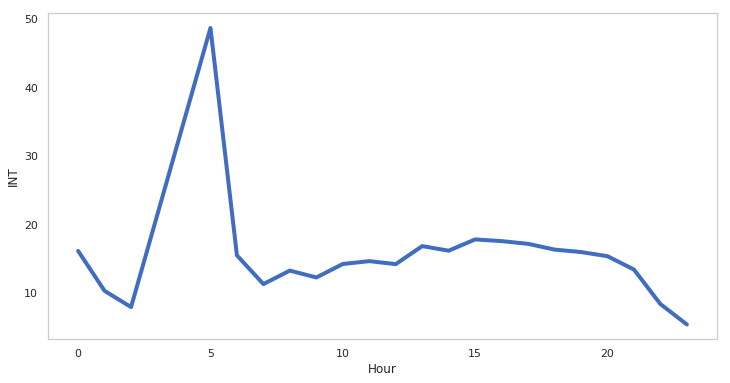

In [0]:
# 계획시각에 따른 지연 비율
sns.set(rc={'figure.figsize':(12,6), "lines.linewidth" : 4}, style="whitegrid")
sns.lineplot(x = 'Hour', y = 'INT', data = AFSNT, ci = None,color='#406dbf')

plt.grid(False)

In [0]:
# 계획 시각에 따른 전체 항공편 수
AFSNT['Delay3']=AFSNT['DLY'].replace("Y",1).replace("N",1)
AFSNT['Delay3'] = list(map(int, AFSNT['Delay3']))
AFSNT_3=AFSNT.loc[:,['Hour','Delay3']]
hour_group3 = AFSNT_3.groupby('Hour', axis = 0).sum()
hour_group3= hour_group3.reset_index()
hour_group3

,Hour,Delay3
0,0,97
1,1,14
2,2,1
3,5,24
4,6,20028
5,7,48908
6,8,65075
7,9,71203
8,10,64535
9,11,65055


J    273201
A    175545
B    134198
H    131244
I     94473
F     87479
L     83301
Name: FLO, dtype: int64


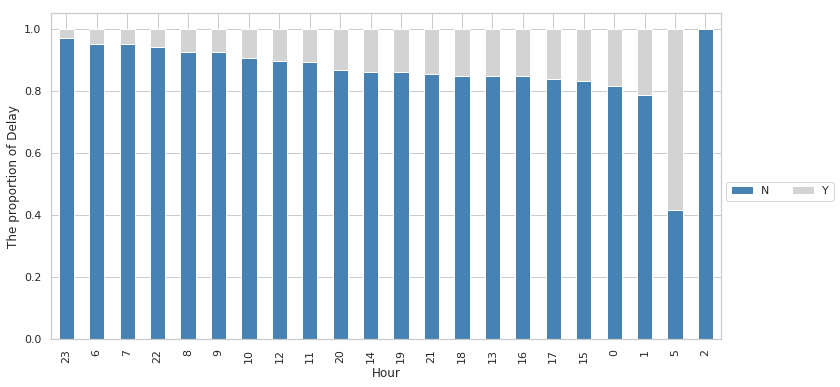

In [0]:
# 계획시간별 지연비율
stack_plot('Hour','DLY',AFSNT)
plt.legend(ncol=5, bbox_to_anchor=(1, 0.5))
plt.ylabel('The proportion of Delay')
print(AFSNT['FLO'].value_counts())

In [0]:
STTtime2 = AFSNT.groupby(['Hour', 'DLY']).size().unstack().transpose()
STTtime2 = STTtime2.div(STTtime2.sum()).fillna(0).transpose().reset_index()
STTtime2['Total'] = STTtime2['N'] + STTtime2['Y']
STTtime2

DLY,Hour,N,Y,Total
0,0,0.814433,0.185567,1.0
1,1,0.785714,0.214286,1.0
2,2,1.000000,0.000000,1.0
3,5,0.416667,0.583333,1.0
4,6,0.952167,0.047833,1.0
5,7,0.951971,0.048029,1.0
6,8,0.925701,0.074299,1.0
7,9,0.924343,0.075657,1.0
8,10,0.904331,0.095669,1.0
9,11,0.891553,0.108447,1.0


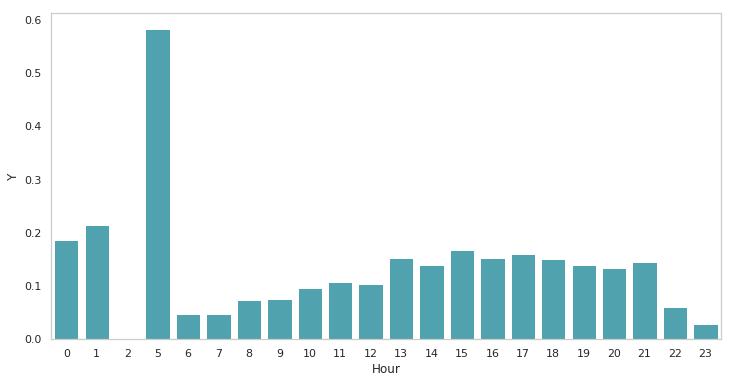

In [0]:

sns.barplot(x="Hour", y="Y", data=STTtime2, color="#40adbf") 
plt.grid(False)

# 날짜 EDA

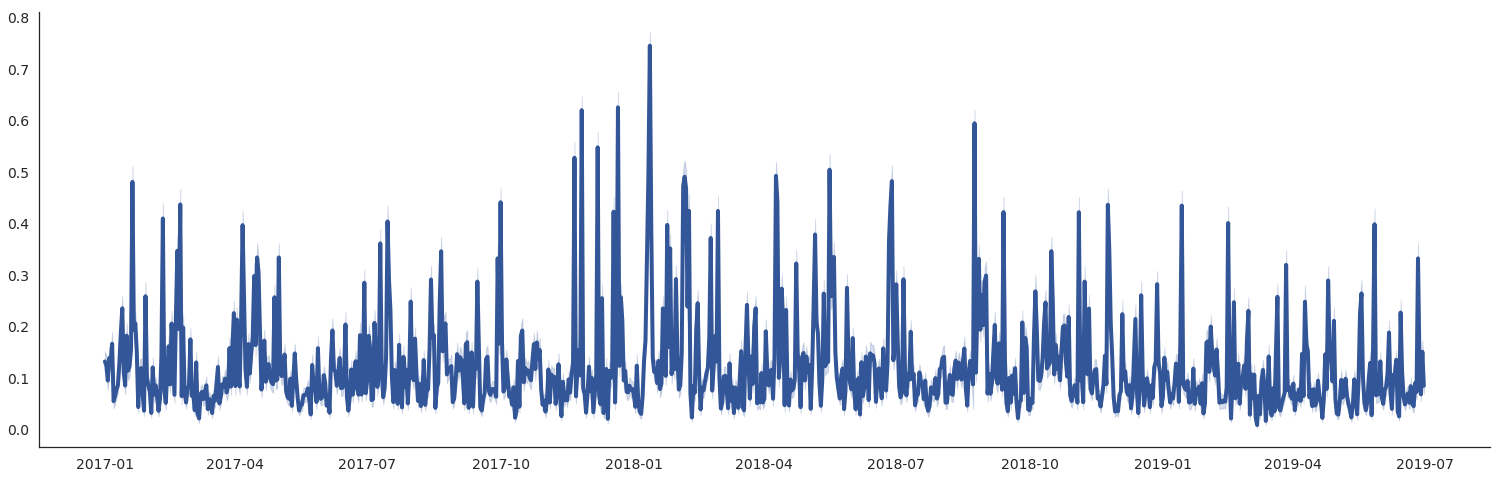

In [0]:
df_ts = AFSNT.loc[:,['Date', 'DLY']]
df_ts['Date'] = pd.to_datetime(df_ts['Date'])
df_ts['DLY'] = df_ts['DLY'].replace('Y', 1).replace('N', 0)

sns.set_style("white")
fig = plt.figure(figsize = (26, 8))
ax = sns.lineplot(x = df_ts['Date'], y = df_ts['DLY'], color = '#335699'); ax.set_xlabel(""); ax.set_ylabel("");
   
for item in ([ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)
    
sns.despine(left=False)

fig.savefig('ts.png')

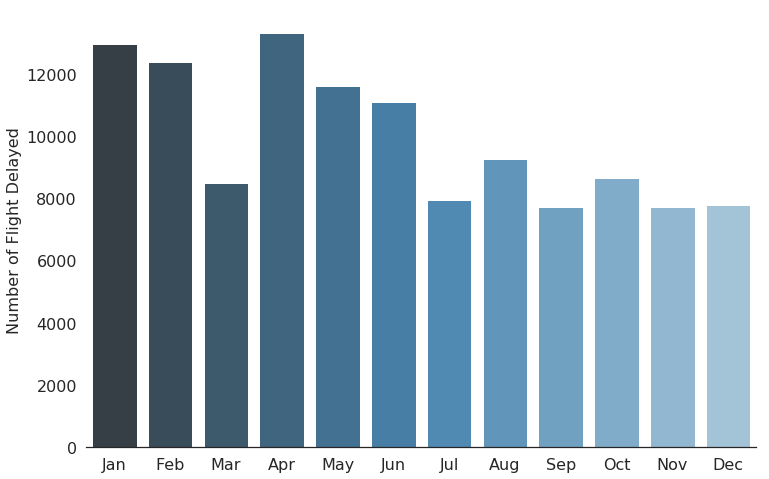

In [0]:
# 월별 지연 항공편 수
df_month = AFSNT.groupby(['Date', 'DLY']).size().unstack().reset_index()
df_month['Date'] = pd.to_datetime(df_month['Date'])
df_month['Month'] = df_month['Date'].dt.month
df_month = df_month.groupby('Month', axis = 0).sum()
df_month = df_month.rename(index = {1 : "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun", 7: "Jul", 8:"Aug", 9:"Sep", 10:"Oct", 11: "Nov", 12: "Dec" })
df_month.reset_index(inplace = True)
df_month

#Create the line plot
fig = plt.figure(figsize = (12, 8))
sns.set_style("white")
#sns.set(rc={'figure.figsize':(12,8)}, style="white")

color = sns.color_palette("Blues_d", n_colors = 12)
ax = sns.barplot(x= 'Month', y = 'Y', data = df_month, palette = color) 

plt.xlabel("")
plt.ylabel("Number of Flight Delayed")

for item in ([ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)

sns.despine(left = True)
plt.show()

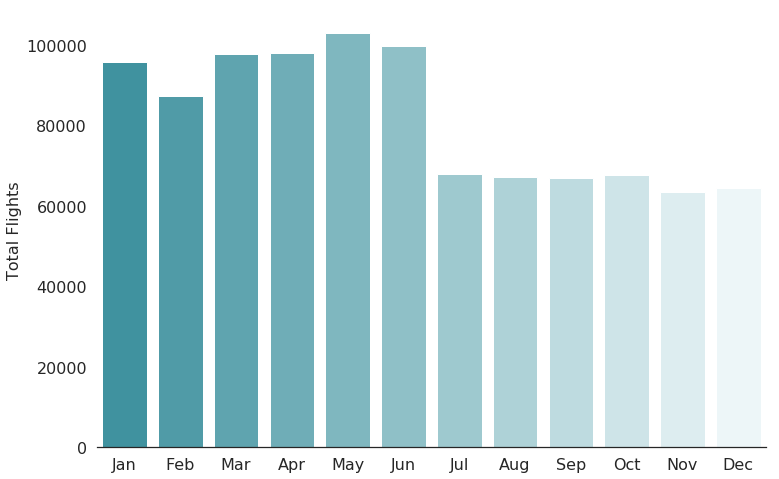

In [0]:
# 월별 전체 항공편 수
df_month2 = AFSNT.groupby(['Date', 'DLY']).size().unstack().reset_index()
df_month2['Date'] = pd.to_datetime(df_month2['Date'])
df_month2['Month'] = df_month2['Date'].dt.month
df_month2['Total'] = df_month2['N'] + df_month2['Y']
df_month2 = df_month2.groupby('Month', axis = 0).sum()
df_month2 = df_month2.rename(index = {1 : "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun", 7: "Jul", 8:"Aug", 9:"Sep", 10:"Oct", 11: "Nov", 12: "Dec" })
df_month2.reset_index(inplace = True)
df_month2

fig = plt.figure(figsize = (12, 8))
sns.set_style("white")

color = sns.light_palette((210, 90, 60), input="husl", n_colors = 12, reverse = True)
ax = sns.barplot(x= 'Month', y = "Total", data = df_month2, palette = color) 

plt.xlabel("")
plt.ylabel("Total Flights")

for item in ([ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)

sns.despine(left = True)
plt.show()

DLY Month  Ratio
0     Jan   0.97
1     Feb   0.93
2     Mar   0.64
3     Apr   1.00
4     May   0.87
5     Jun   0.83
6     Jul   0.60
7     Aug   0.70
8     Sep   0.58
9     Oct   0.65
10    Nov   0.58
11    Dec   0.58


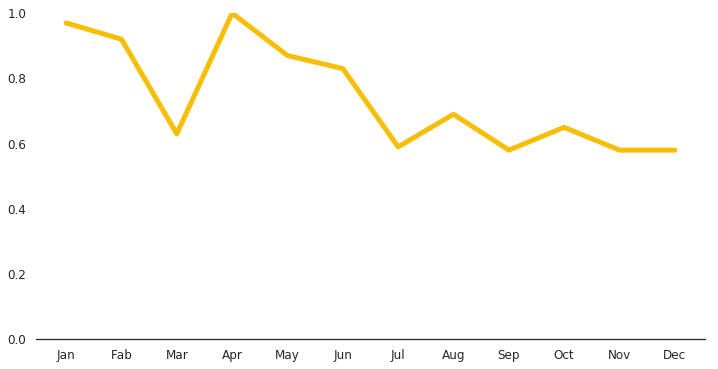

In [0]:
#Line plot
df_month2 = AFSNT.groupby(['Date', 'DLY']).size().unstack().reset_index()
df_month2['Date'] = pd.to_datetime(df_month2['Date'])
df_month2['Month'] = df_month2['Date'].dt.month
df_month2['Total'] = df_month2['N'] + df_month2['Y']
df_month2 = df_month2.groupby('Month', axis = 0).sum()
df_month2 = df_month2.rename(index = {1 : "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun", 7: "Jul", 8:"Aug", 9:"Sep", 10:"Oct", 11: "Nov", 12: "Dec" })
df_month2.reset_index(inplace = True)
scaling = df_month2['Y'] / df_month2['Y'].max()
df_month2['Ratio'] = round(scaling, 2)
df_month2=df_month2.loc[:,['Month','Ratio']]
print(df_month2.head(12))

month_order=['Jan','Fab','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

dfm = pd.DataFrame(columns=['Month', 'Ratio'])

dfm['Month']=['Jan','Fab','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
dfm['Ratio']=[0.97,0.92,0.63,1.00,0.87,0.83,0.59,0.69,0.58,0.65,0.58,0.58]

dfm['Month'] = pd.Categorical(dfm['Month'],ordered=False, categories=month_order)
#ax = sns.lineplot(x='Month', y='Ratio', data=dfm,color="BLACK")


sns.set_style("white")
ax = sns.lineplot(x = 'Month', y = 'Ratio', data = dfm, color = "#F7BE07", linewidth=5); ax.set_xlabel(""); ax.set_ylabel("")

for item in ([ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax.set(ylim = (0, 1))
    
    
sns.despine(left=True)

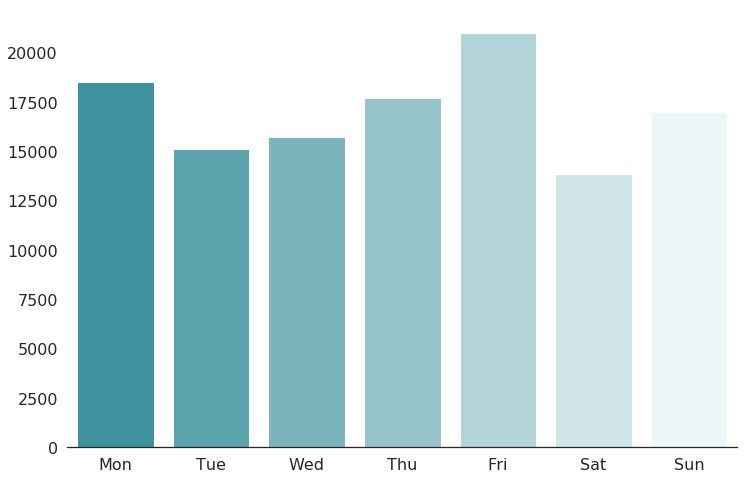

In [0]:
# 요별 지연 항공편 수
df_dow = AFSNT.loc[:, ['Date', 'DLY']]
df_dow['DLY'] = df_dow['DLY'].replace("Y", 1).replace("N", 0)
df_dow['Date'] = pd.to_datetime(df_dow['Date'])
df_dow['DOW'] = df_dow['Date'].dt.strftime('%a')
grp_dow = df_dow.groupby('DOW', axis = 0).sum()
grp_dow.reset_index(inplace = True)
grp_dow.set_index('DOW', append = False, inplace = True)
grp_dow = grp_dow.transpose()
grp_dow = grp_dow[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']].transpose()
grp_dow.reset_index(inplace = True)
grp_dow

fig = plt.figure(figsize = (12, 8))
sns.set_style("white")

sub_color = sns.light_palette((210, 90, 60), input="husl", n_colors = 7, reverse = True)
ax = sns.barplot(x= 'DOW', y = 'DLY', data = grp_dow, palette = sub_color)
plt.xlabel("")
plt.ylabel("")

for item in ([ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)
    
sns.despine(left=True)
plt.show()


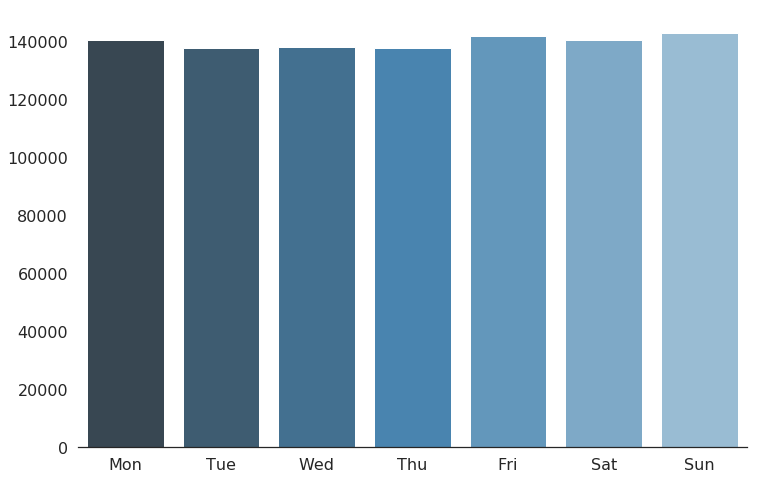

In [0]:
# 월별 전체 항공편 수
df_dow2 = AFSNT.groupby(['Date', 'DLY']).size().unstack().reset_index()
df_dow2['Date'] = pd.to_datetime(df_dow2['Date'])
df_dow2['DOW'] = df_dow2['Date'].dt.strftime('%a')
df_dow2['Total'] = df_dow2['N'] + df_dow2['Y']
df_dow2 = df_dow2.groupby('DOW', axis = 0).sum().transpose()
df_dow2 = df_dow2[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']].transpose().reset_index()
df_dow2

fig = plt.figure(figsize = (12, 8))
sns.set_style("white")

color = sns.color_palette("Blues_d", n_colors = 7)
ax = sns.barplot(x= 'DOW', y = 'Total', data = df_dow2, palette = color)
plt.xlabel("")
plt.ylabel("")

for item in ([ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)
sns.despine(left=True)
plt.show()

   DOW    DLY  Ratio
0  Mon  18540   0.88
1  Tue  15098   0.72
2  Wed  15712   0.75
3  Thu  17726   0.84
4  Fri  20993   1.00
5  Sat  13867   0.66
6  Sun  17001   0.81


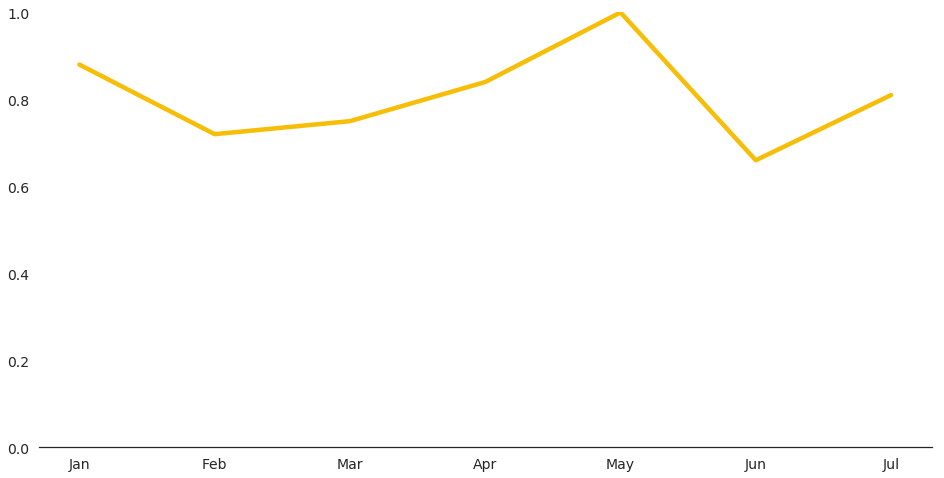

In [0]:
# 요일별 지연비율
grp_dow['Ratio'] = round(grp_dow['DLY'] / grp_dow['DLY'].max(), 2)

fig = plt.figure(figsize = (16, 8))
sns.set_style("white")
ax.tick_params(length=6, width=2)


print(grp_dow.head(7))

values = np.array(grp_dow['Ratio'])
days = np.array(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

grp_dow['DOW'] = pd.Categorical(grp_dow['DOW'],ordered=False, categories=days)

plt.xticks(range(len(values)), month)

with plt.rc_context({'lines.linewidth': 4.5}):
  ax = sns.lineplot(x = 'DOW', y = 'Ratio', data = grp_dow, color = "#F7BE07"); ax.set_xlabel(""); ax.set_ylabel("")

for item in ([ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(14)
    

ax.set(ylim = (0, 1)) 
sns.despine(left=True)
plt.show()


# 공항 EDA

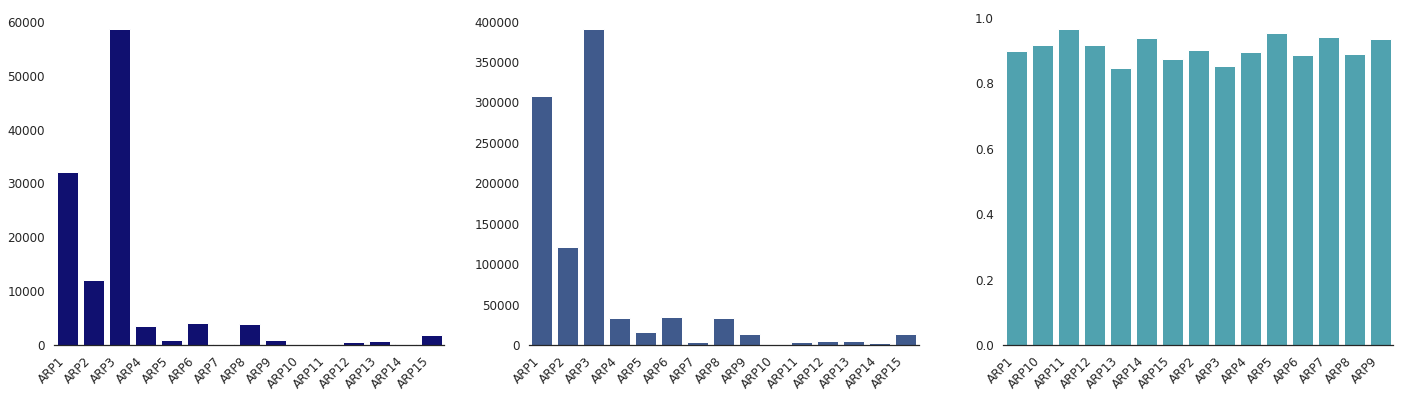

In [0]:
#항공편 수
df_arp = AFSNT.groupby(['ARP', 'DLY']).size().unstack()
df_arp['Total'] = df_arp['N'] + df_arp['Y']
df_arp = df_arp.loc[['ARP1', 'ARP2', 'ARP3', 'ARP4', 'ARP5', 'ARP6', 'ARP7', 'ARP8', 'ARP9', 'ARP10', 'ARP11', 'ARP12', 'ARP13', 'ARP14', 'ARP15'], :].reset_index()

#비율
df_arp2 = AFSNT.groupby(['ARP', 'DLY']).size().unstack().transpose()
df_arp2 = df_arp2.div(df_arp2.sum()).fillna(0).transpose().reset_index()
df_arp2['Total'] = df_arp2['N'] + df_arp2['Y']

sns.set_style("white")
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 6))
fig.autofmt_xdate(rotation = 45)
#fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 10))

sns.barplot(x = df_arp['ARP'], y = df_arp['Y'], color = 'navy', ax = ax1); ax1.set_xlabel(""); ax1.set_ylabel("") 
sns.barplot(x = df_arp['ARP'], y = df_arp['Total'], color = "#335699", ax = ax2); ax2.set_xlabel(""); ax2.set_ylabel("")
sns.barplot(x = df_arp2['ARP'], y = df_arp2['N'], color = '#40adbf', ax = ax3); ax3.set_xlabel(""); ax3.set_ylabel("")
#ax1.set_xlabel(""); ax1.set_ylabel("");


sns.despine(left=True)
for item in ([ax1.xaxis.label, ax1.yaxis.label] +
             ax1.get_xticklabels() + ax1.get_yticklabels()):
    item.set_fontsize(12)
for item in ([ax2.xaxis.label, ax2.yaxis.label] +
             ax2.get_xticklabels() + ax2.get_yticklabels()):
    item.set_fontsize(12)
for item in ([ax3.xaxis.label, ax3.yaxis.label] + ax3.get_xticklabels() + ax3.get_yticklabels()):
    item.set_fontsize(12)    
plt.tight_layout(pad = 2)

# 날씨, holiday EDA 추가

In [0]:
AFSNT.head()

,Date,ARP,ODP,FLO,FLT,REG,AOD,IRR,STT,ATT,DLY,DRR,CNL,CNR,flights,STT_minute,STT_category,slots,STT_detail,ATT_detail,INT,Weekday,ATT_minute,Hour,new_DRR,Delay2,Delay3
0,2017-01-01,ARP1,ARP3,A,A1901,SEw3Nzc2,D,N,6:10,6:18,N,NaN,N,NaN,344,370.0,2,14,2017-01-01 06:10:00,2017-01-01 06:18:00,8.0,6,378.0,6,NaN,0,1
1,2017-01-01,ARP1,ARP3,A,A1905,SEw4MjM2,D,N,6:15,6:25,N,NaN,N,NaN,344,375.0,2,14,2017-01-01 06:15:00,2017-01-01 06:25:00,10.0,6,385.0,6,NaN,0,1
2,2017-01-01,ARP1,ARP3,L,L1751,SEw4MjM3,D,N,6:20,6:30,N,NaN,N,NaN,344,380.0,2,14,2017-01-01 06:20:00,2017-01-01 06:30:00,10.0,6,390.0,6,NaN,0,1
3,2017-01-01,ARP1,ARP3,F,F1201,SEw4MjA3,D,N,6:25,6:34,N,NaN,N,NaN,344,385.0,2,14,2017-01-01 06:25:00,2017-01-01 06:34:00,9.0,6,394.0,6,NaN,0,1
4,2017-01-01,ARP1,ARP3,H,H1101,SEw4MDMx,D,N,6:30,6:38,N,NaN,N,NaN,344,390.0,2,14,2017-01-01 06:30:00,2017-01-01 06:38:00,8.0,6,398.0,6,NaN,0,1


In [0]:
import copy
drop_list=['REG','ATT','STT','ATT','CNL','CNR','STT_category','STT_detail','ATT_detail','INT','ATT_minute','Hour','new_DRR','Delay2','Delay3']
afsnt=copy.deepcopy(AFSNT)
afsnt.drop(drop_list,axis=1,inplace=True)

- EDA final 문서에서 앞으로 모델 학습을 위한 전처리 파일을 저장한다. 

In [0]:
afsnt.to_csv('/content/gdrive/My Drive/test_colab/afsnt_pre.csv',encoding='utf-8')

In [0]:
pd.read_csv('/content/gdrive/My Drive/test_colab/afsnt_pre.csv',encoding='utf-8',index_col=0)

,Date,ARP,ODP,FLO,FLT,AOD,IRR,DLY,DRR,flights,STT_minute,slots,Weekday
0,2017-01-01,ARP1,ARP3,A,A1901,D,N,N,NaN,344,370.0,14,6
1,2017-01-01,ARP1,ARP3,A,A1905,D,N,N,NaN,344,375.0,14,6
2,2017-01-01,ARP1,ARP3,L,L1751,D,N,N,NaN,344,380.0,14,6
3,2017-01-01,ARP1,ARP3,F,F1201,D,N,N,NaN,344,385.0,14,6
4,2017-01-01,ARP1,ARP3,H,H1101,D,N,N,NaN,344,390.0,14,6
5,2017-01-01,ARP1,ARP3,I,I1301,D,N,N,NaN,344,390.0,14,6
6,2017-01-01,ARP1,ARP3,A,A1907,D,N,Y,C01,344,400.0,14,6
7,2017-01-01,ARP1,ARP3,I,I1303,D,N,N,NaN,344,400.0,14,6
8,2017-01-01,ARP1,ARP3,J,J1204,D,N,N,NaN,344,405.0,14,6
9,2017-01-01,ARP1,ARP3,A,A1903,D,N,N,NaN,344,405.0,14,6
